# load things for science :)

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot
import matplotlib.cm
import math
import sys
import csv
from scipy import integrate
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import FloatSlider, Layout, HBox, VBox, Label, Output, Button, IntProgress, HTML
from IPython.display import display, clear_output
%matplotlib widget

In [3]:
# change folder name to 'experiment' or 'simulation' or 'threepion_sim'
folder_name = "experiment"
# OneDrive = "OneDrive - University of South Carolina"

# choose a csv file corresponding to the above folder_name
csv_file = pd.read_csv(f"/Users/aosmond/nuclearPhys/csv/finished_csv/10_6GeV/exp/10_6exp_excl_jlab_09_12_2025.csv", index_col=False)
# csv_file = pd.read_csv("/Users/aosmond/nuclearPhys/csv/finished_csv/10_6GeV/testweight/10_6rec_excl_jlab_09_24_2025.csv", index_col=False)
# csv_file = pd.read_csv("/Users/osmondal/nuclearPhys/csv/finished_csv/10_6GeV/threepion/10_6rec_excl_3pion_withBG_jlab_07_22_2025.csv", index_col=False)

# read in threepion background csv (for exp and rec bg comparisons)
threepion_csv = pd.read_csv(f"/Users/aosmond/nuclearPhys/csv/finished_csv/10_6GeV/threepion/10_6rec_excl_3pion_withBG_jlab_07_22_2025.csv", index_col=False)

# base path for future hists
hist_base_path = Path(f'/Users/aosmond/nuclearPhys/notebooks/notebook_hists/{folder_name}/EXCL_topology')
csv_base_path = Path(f'/Users/aosmond/nuclearPhys/notebooks/notebook_csvs/{folder_name}/EXCL_topology')


In [3]:
# bins_value = 100
# step = 0.001

# topologies = {
#     "excl": (-0.03, 0.03),
#     "mProt": (-0.1, 2.5),
#     "mPip": (-0.4, 0.6),
#     "mPim": (-0.4, 0.6) }

# # dictionary for fwhm values
# fwhm_values_slider = {}
# fwhm_values_systematic = {}

# # Store figures and sliders (slider data only)
# topo_boxes = []
# topo_data = {}

# theta_boxes = []
# theta_data = {}

# momentum_boxes = []
# momentum_data = {}

# # --- Define all topo keys: MM² topologies + theta + momentum cuts ---
# theta_cuts = ["prot_theta", "pip_theta", "pim_theta"]
# momentum_cuts = ["momentum_prot", "momentum_pip", "momentum_pim"]

# all_topo_keys = list(topologies.keys()) + theta_cuts + momentum_cuts

# # Precompute DataFrames (store full event data for each topo)
# for topo in all_topo_keys:
#     df_full = csv_file.copy()
#     topo_data[topo] = {
#         "data": df_full,
#         "inside_df": df_full.copy(), # initialize so no keyerror
#         "outside_df": df_full.copy(),
#     }

# # for systematic cuts
# # MM² cuts (from Gaussian/FWHM fits)
# for topo, info in fwhm_values_systematic.items():
#     left_in, right_in = info["in_region"]
#     left_out, right_out = info["out_region"]
    
#     csv_file[f"{topo}_in"] = ((csv_file[f"mm2_{topo}"] >= left_in) & 
#                                (csv_file[f"mm2_{topo}"] <= right_in)).astype(int)
#     csv_file[f"{topo}_out"] = 1 - csv_file[f"{topo}_in"]

# # Theta systematic cuts (use left/right from theta_data)
# for particle, pdata in theta_data.items():
#     left, right = pdata["left_cut"], pdata["right_cut"]
#     col_name = f"theta_{particle}"
#     csv_file[f"{col_name}_in"] = ((csv_file[f"{particle}_theta_angle_btwn_P"] >= left) &
#                                    (csv_file[f"{particle}_theta_angle_btwn_P"] <= right)).astype(int)
#     csv_file[f"{col_name}_out"] = 1 - csv_file[f"{col_name}_in"]

# # Momentum systematic cuts (use left/right from momentum_data)
# for particle, pdata in momentum_data.items():
#     left, right = pdata["left_cut"], pdata["right_cut"]
#     col_name = f"momentum_{particle}"
#     momentum_diff = csv_file[f"{particle}_mom_miss"] - csv_file[f"{particle}_mom_meas"]
#     csv_file[f"{col_name}_in"] = ((momentum_diff >= left) & (momentum_diff <= right)).astype(int)
#     csv_file[f"{col_name}_out"] = 1 - csv_file[f"{col_name}_in"]


In [4]:
# # --- Define base cut groups ---
# mm2_cuts = {
#     "excl":  ["mPim", "mProt", "mPip"],
#     "mProt": ["mPim", "excl", "mPip"],
#     "mPip":  ["mPim", "excl", "mProt"],
#     "mPim":  ["mPip", "excl", "mProt"],
# }

# # --- Function to build rules ---
# def build_rules(in_or_out="out"):
#     rules = {}
#     for topo, mm2_list in mm2_cuts.items():
#         mm2 = [f"{cut}_{in_or_out}" for cut in mm2_list]
#         theta = [f"{cut}_{in_or_out}" for cut in theta_cuts]
#         momentum   = [f"{cut}_{in_or_out}" for cut in momentum_cuts]
        
#         # combine
#         rules[topo] = mm2 + theta + momentum
        
#     return rules

# # --- Build background & signal rules ---
# background_rules = build_rules("out")
# signal_rules     = build_rules("in")

In [4]:
bins_value = 100
step = 0.001

# --- Define MM² ranges for each topology ---
topologies = {
    "excl": (-0.03, 0.03),
    "mProt": (-0.1, 2.5),
    "mPip": (-0.4, 0.6),
    "mPim": (-0.4, 0.6),
}

# # --- Define theta and momentum cut variable names ---
# theta_cuts = ["theta_prot", "theta_pip", "theta_pim"]
# momentum_cuts = ["momentum_prot", "momentum_pip", "momentum_pim"]

# # --- Build list of all variables that have _in/_out flags ---
# all_cut_vars = list(topologies.keys()) + theta_cuts + momentum_cuts

# # --- Build mapping of which MM² cuts to use for each topology ---
# mm2_cuts = {
#     "excl":  ["mPim", "mProt", "mPip"],
#     "mProt": ["mPim", "excl", "mPip"],
#     "mPip":  ["mPim", "excl", "mProt"],
#     "mPim":  ["mPip", "excl", "mProt"],
# }

# for topo in topologies.keys():  # ["excl", "mProt", "mPip", "mPim"]
#     csv_file[f"{topo}_in"] = csv_file["event"].isin(mm2_data[topo]["inside_df"]["event"])
#     csv_file[f"{topo}_out"] = csv_file["event"].isin(mm2_data[topo]["outside_df"]["event"])

# for particle in theta_cuts:  # ["theta_prot", "theta_pip", "theta_pim"]
#     csv_file[f"{particle}_in"] = csv_file["event"].isin(theta_data[particle]["inside_df"]["event"])
#     csv_file[f"{particle}_out"] = csv_file["event"].isin(theta_data[particle]["outside_df"]["event"])

# for particle in momentum_cuts:  # ["momentum_prot", "momentum_pip", "momentum_pim"]
#     csv_file[f"{particle}_in"] = csv_file["event"].isin(momentum_data[particle]["inside_df"]["event"])
#     csv_file[f"{particle}_out"] = csv_file["event"].isin(momentum_data[particle]["outside_df"]["event"])

# # --- Function to build selection rules ---
# def build_rules(in_or_out):
#     rules = {}
#     for topo, others in mm2_cuts.items():
#         # MM² cuts: use all other topologies’ in/out columns
#         mm2_cols = [f"{o}_{in_or_out}" for o in others]
#         # Theta and momentum cuts: all same in/out
#         theta_cols = [f"{t}_{in_or_out}" for t in theta_cuts]
#         mom_cols   = [f"{m}_{in_or_out}" for m in momentum_cuts]
#         # Combine all relevant cuts
#         rules[topo] = mm2_cols + theta_cols + mom_cols
#     return rules

# # --- Define signal and background rules ---
# signal_rules = build_rules("in")
# background_rules = build_rules("out")

In [6]:
# --- Choose scale factors per topology (scale signal histogram to % of max(all events)) --- 
signal_scale_factors = { 
    "excl": 0.95, 
    "mProt": 0.95, 
    "mPip": 0.95, 
    "mPim": 0.88 
} 

# --- Choose widen sigma per topology (in units of bins) --- 
signal_widen_sigmas = {
    "excl": 0.25,
    "mProt": 0.25, 
    "mPip": 0.25, 
    "mPim": 0.350 
}

# w-q2 range

In [11]:
# w and q2 ranges
w_bin_ranges = np.append(np.arange(1.4, 2.5, 0.05), 2.5)
q2_bin_ranges = [2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,11.0] #,13.0]

/var/folders/wd/z4b9mvxs2xb0v8hc2svy1l580000gp/T/ipykernel_54929/539917474.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))
/var/folders/wd/z4b9mvxs2xb0v8hc2svy1l580000gp/T/ipykernel_54929/539917474.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis'),


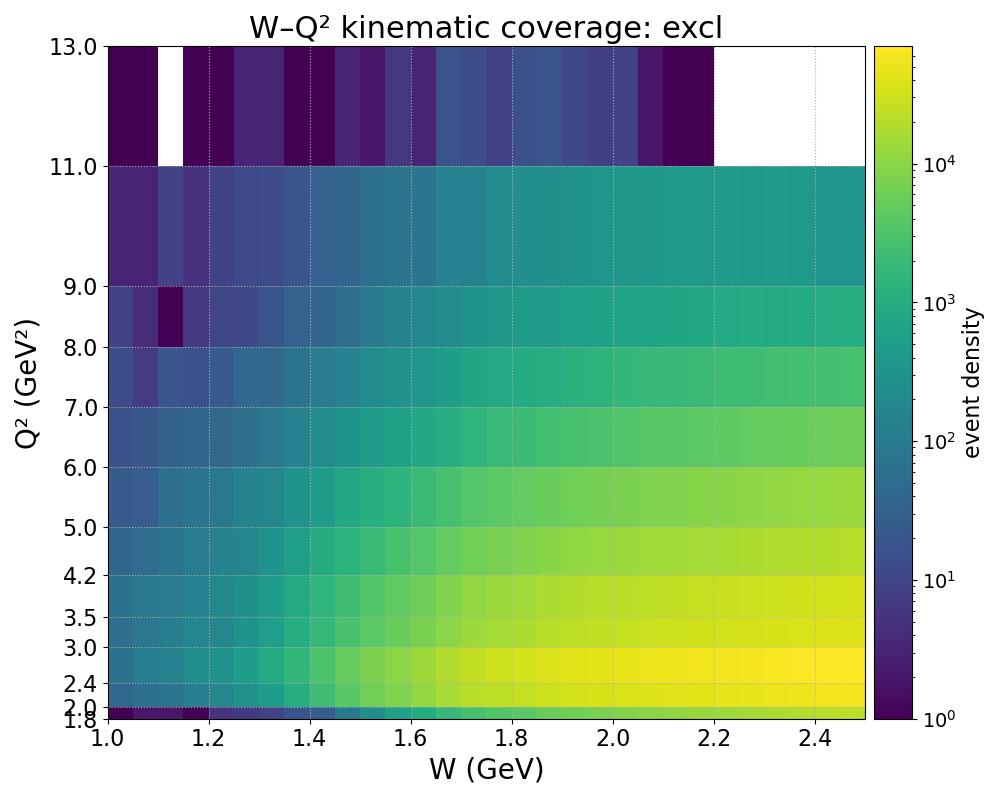

In [30]:
# --- W vs Q² coverage for each topology, with bin gridlines ---

import matplotlib.pyplot as plt

# Define which dataset to visualize
dataset = csv_file  # or exp_csv / rec_csv

w_range = np.append(np.arange(1.0, 2.5, 0.05), 2.5)
q2_range = [1.8,2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,11.0,13.0]

# --- W vs Q² histograms with colorbars for each topology ---

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np


# Define bin edges from your ranges
bin_x = w_range
bin_y = q2_range

# for topo in topologies:
fig, ax = plt.subplots(figsize=(10, 8))

mask = dataset[f"mm2_{topo}"].notna()
w_vals = dataset.loc[mask, "w"].to_numpy()
q2_vals = dataset.loc[mask, "q2"].to_numpy()

# 2D histogram — color represents event density
h = ax.hist2d(
    w_vals, q2_vals,
    bins=[bin_x, bin_y],
    cmap=plt.cm.get_cmap('viridis'),
    cmin=1,  # ignore empty bins
    norm=mpl.colors.LogNorm(),  # log color scale for better contrast
    density=False
)

# Title and axes
ax.set_title(f"W–Q² kinematic coverage: {topo}", fontsize=22)
ax.set_xlabel("W (GeV)", fontsize=20)
ax.set_ylabel("Q² (GeV²)", fontsize=20)

# Colorbar setup
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
cb = plt.colorbar(h[3], cax=cax)
cb.set_label("event density", fontsize=16)
cb.ax.tick_params(labelsize=14)

# Grid and ticks
ax.grid(which='both', linestyle=':')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(bin_x[::4])  # every 2nd tick
ax.set_yticks(bin_y)

plt.tight_layout()
plt.show()


# sliders

## slider cuts

In [ ]:
# precompute DataFrames (store full event data for each topo)
for topo in topologies:
    topo_data[topo] = {"data": csv_file.copy()}   # keep full df, not just mm2 slice

# ---- Function to create plot + sliders ----
def create_topology_plot(topo, x_min, x_max):
    plot_out = Output()

    slider_layout = Layout(width='250px', height='40px')

    # --- Inside sliders ---
    inside_left_slider = FloatSlider(min=x_min, max=x_max, step=0.0005, value=x_min, layout=slider_layout,
                                     continuous_update=True, description='In L', readout=False)
    inside_right_slider = FloatSlider(min=x_min, max=x_max, step=0.0005, value=x_max, layout=slider_layout,
                                      continuous_update=True, description='In R', readout=False)

    # --- Outside sliders ---
    outside_left_slider = FloatSlider(min=x_min, max=x_max, step=0.0005, value=x_min, layout=slider_layout,
                                      continuous_update=True, description='Out L', readout=False)
    outside_right_slider = FloatSlider(min=x_min, max=x_max, step=0.0005, value=x_max, layout=slider_layout,
                                       continuous_update=True, description='Out R', readout=False)

    slider_box = VBox([
        HBox([inside_left_slider, inside_right_slider]),
        HBox([outside_left_slider, outside_right_slider])
    ])

    with plot_out:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(topo_data[topo]["data"][f'mm2_{topo}'], bins=bins_value, range=(x_min, x_max), alpha=0.75, color='black', histtype='step', linewidth=0.8)
        ax.set_title(f"MM² exclusive {topo}", fontsize=14)
        ax.set_xlabel('MM² (GeV²)', fontsize=10)
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)

        # Vertical lines for inside cuts (purple)
        in_left_line = ax.axvline(inside_left_slider.value, color='blueviolet', linestyle='--')
        in_right_line = ax.axvline(inside_right_slider.value, color='blueviolet', linestyle='--')

        # Vertical lines for outside cuts (green)
        out_left_line = ax.axvline(outside_left_slider.value, color='green', linestyle='--')
        out_right_line = ax.axvline(outside_right_slider.value, color='green', linestyle='--')

        legend = ax.legend([in_left_line, in_right_line, out_left_line, out_right_line],
            [f'in L={inside_left_slider.value:.3f}', f'in R={inside_right_slider.value:.3f}',
             f'out L={outside_left_slider.value:.3f}', f'out R={outside_right_slider.value:.3f}'], fontsize=10
        )
        plt.show()

    # Update function
    def update_cuts(change=None, ax=ax, in_left=in_left_line, in_right=in_right_line, out_left=out_left_line, out_right=out_right_line, fig=fig):

        in_l, in_r = inside_left_slider.value, inside_right_slider.value
        out_l, out_r = outside_left_slider.value, outside_right_slider.value

        # update vertical lines
        in_left.set_xdata([in_l, in_l])
        in_right.set_xdata([in_r, in_r])
        out_left.set_xdata([out_l, out_l])
        out_right.set_xdata([out_r, out_r])

        ax.legend([in_left, in_right, out_left, out_right], [f'in L={in_l:.3f}', f'in R={in_r:.3f}', f'out L={out_l:.3f}', f'out R={out_r:.3f}'], fontsize=10)

        # recompute masks
        inside_mask = (csv_file[f"mm2_{topo}"] >= in_l) & (csv_file[f"mm2_{topo}"] <= in_r)
        outside_mask = (csv_file[f"mm2_{topo}"] <= out_l) | (csv_file[f"mm2_{topo}"] >= out_r)

        # store dfs in memory
        topo_data[topo]["inside_df"] = csv_file[inside_mask]
        topo_data[topo]["outside_df"] = csv_file[outside_mask]

        fig.canvas.draw_idle()

    # Attach observers
    inside_left_slider.observe(update_cuts, names='value')
    inside_right_slider.observe(update_cuts, names='value')
    outside_left_slider.observe(update_cuts, names='value')
    outside_right_slider.observe(update_cuts, names='value')

    # Store sliders in topo_data for later use
    topo_data[topo]["inside_left_slider"] = inside_left_slider
    topo_data[topo]["inside_right_slider"] = inside_right_slider
    topo_data[topo]["outside_left_slider"] = outside_left_slider
    topo_data[topo]["outside_right_slider"] = outside_right_slider

    # Initialize
    update_cuts()

    return VBox([plot_out, slider_box])

# ---- Build grid of plots ----
for topo, (x_min, x_max) in topologies.items():
    topo_boxes.append(create_topology_plot(topo, x_min, x_max))

row1 = HBox([topo_boxes[0], topo_boxes[1]])
row2 = HBox([topo_boxes[2], topo_boxes[3]])
display(VBox([row1, row2]))


In [ ]:
x_min, x_max = -5, 30
x_range = x_max - x_min

# Store figures, sliders, and data
# theta_boxes = []
# theta_data = {}

# Precompute DataFrames (store full event data for each particle)
for particle in ["prot", "pip", "pim"]:
    theta_data[particle] = {"data": csv_file.copy()}

# Function to create theta plot + sliders
def create_theta_plot(particle, x_min, x_max):
    plot_out = Output()

    slider_layout = Layout(width='250px', height='40px')
    left_slider = FloatSlider(min=x_min, max=x_max, step=0.5, value=x_min, layout=slider_layout, continuous_update=True, description='Left', readout=False)
    right_slider = FloatSlider(min=x_min, max=x_max, step=0.5, value=x_max, layout=slider_layout, continuous_update=True, description='Right', readout=False)

    slider_box = HBox([left_slider, right_slider])

    with plot_out:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(csv_file[f"{particle}_theta_angle_btwn_P"], bins=bins_value, range=(x_min, x_max), alpha=0.75, color="black", histtype="step", linewidth=0.8)
        ax.set_title(f"{particle} θ difference", fontsize=14)
        ax.set_xlabel("θ difference (deg)", fontsize=10)
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)

        left_line = ax.axvline(left_slider.value, color="blueviolet", linestyle="--")
        right_line = ax.axvline(right_slider.value, color="blueviolet", linestyle="--")
        legend = ax.legend([left_line, right_line], [f"Left = {left_slider.value:.1f}", f"Right = {right_slider.value:.1f}"], fontsize=10)
        plt.show()

    # Update cut lines + store inside/outside
    def update_cuts(change=None, ax=ax, left_line=left_line, right_line=right_line, fig=fig):
        left = left_slider.value
        right = right_slider.value

        left_line.set_xdata([left, left])
        right_line.set_xdata([right, right])
        ax.legend([left_line, right_line], [f"left: {left:.1f}", f"right: {right:.1f}"], fontsize=10)

        inside_mask = (csv_file[f"{particle}_theta_angle_btwn_P"] >= left) & (csv_file[f"{particle}_theta_angle_btwn_P"] <= right)
        outside_mask = ~inside_mask

        topo_data[f"theta_{particle}"] = {
            "inside_df": csv_file[inside_mask],
            "outside_df": csv_file[outside_mask],
        }

        fig.canvas.draw_idle()

    # connect sliders
    left_slider.observe(update_cuts, names="value")
    right_slider.observe(update_cuts, names="value")

    # store sliders
    theta_data[particle]["left_slider"] = left_slider
    theta_data[particle]["right_slider"] = right_slider

    # initialize
    update_cuts()

    return VBox([plot_out, slider_box])

# build grid of plots
for particle in ["prot", "pip", "pim"]:
    theta_boxes.append(create_theta_plot(particle, x_min, x_max))

row1 = HBox([theta_boxes[0], theta_boxes[1]])
row2 = HBox([theta_boxes[2]])
display(VBox([row1, row2]))


In [ ]:
x_min, x_max = -1.0, 2.0
x_range = x_max - x_min

# Store figures, sliders, and data
momentum_boxes = []
momentum_data = {}

# Precompute DataFrames (store full event data for each particle)
for particle in ["prot", "pip", "pim"]:
    momentum_data[particle] = {"data": csv_file.copy()}

# ---- Function to create momentum plot + sliders ----
def create_momentum_plot(particle, x_min, x_max):
    plot_out = Output()

    slider_layout = Layout(width='250px', height='40px')
    left_slider = FloatSlider(min=x_min, max=x_max, step=0.01, value=x_min, layout=slider_layout, continuous_update=True, description='Left', readout=False)
    right_slider = FloatSlider(min=x_min, max=x_max, step=0.01, value=x_max, layout=slider_layout, continuous_update=True, description='Right', readout=False)

    slider_box = HBox([left_slider, right_slider])

    momentum_diff = csv_file[f"{particle}_mom_miss"] - csv_file[f"{particle}_mom_meas"]

    with plot_out:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(momentum_diff, bins=bins_value, range=(x_min, x_max), alpha=0.75, color="black", histtype="step", linewidth=0.8)
        ax.set_title(f"{particle} momentum difference", fontsize=14)
        ax.set_xlabel("momentum difference (GeV)", fontsize=10)
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)

        left_line = ax.axvline(left_slider.value, color="blueviolet", linestyle="--")
        right_line = ax.axvline(right_slider.value, color="blueviolet", linestyle="--")
        legend = ax.legend([left_line, right_line], [f"Left = {left_slider.value:.1f}", f"Right = {right_slider.value:.1f}"], fontsize=10)
        plt.show()

    # --- Update cut lines + store inside/outside ---
    def update_cuts(change=None, ax=ax, left_line=left_line, right_line=right_line, fig=fig):
        left = left_slider.value
        right = right_slider.value

        left_line.set_xdata([left, left])
        right_line.set_xdata([right, right])
        ax.legend([left_line, right_line], [f"left: {left:.1f}", f"right: {right:.1f}"], fontsize=10)

        inside_mask = (momentum_diff >= left) & (momentum_diff <= right)
        outside_mask = ~inside_mask

        topo_data[f"mom_{particle}"] = {
            "inside_df": csv_file[inside_mask],
            "outside_df": csv_file[outside_mask],
        }

        fig.canvas.draw_idle()

    # Connect sliders
    left_slider.observe(update_cuts, names="value")
    right_slider.observe(update_cuts, names="value")

    # Store sliders
    momentum_data[particle]["left_slider"] = left_slider
    momentum_data[particle]["right_slider"] = right_slider

    # Initialize
    update_cuts()

    return VBox([plot_out, slider_box])

# ---- Build grid of plots ----
for particle in ["prot", "pip", "pim"]:
    momentum_boxes.append(create_momentum_plot(particle, x_min, x_max))

row1 = HBox([momentum_boxes[0], momentum_boxes[1]])
row2 = HBox([momentum_boxes[2]])
display(VBox([row1, row2]))


## gaussian fit signal for fwhm

In [ ]:
def plot_slider_results_grid():
    fig, axes = plt.subplots(2, 2, figsize=(11, 7))
    axes = axes.flatten()

    for i, topo in enumerate(topologies):
        ax = axes[i]
        x_min, x_max = topologies[topo]

        # --- Experimental data ---
        csv_data = csv_file[f"mm2_{topo}"]
        csv_hist, bins = np.histogram(csv_data, bins=bins_value, range=(x_min, x_max))
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax.step(bin_centers, csv_hist, where="mid", color="black", alpha=0.6, linewidth=0.7, label="all events")

        threepion_hist, _ = np.histogram(threepion_csv[f'mm2_{topo}'], bins=bins, range=(x_min, x_max))

        bg_hist = bg_hist_scaled = None
        sig_hist = sig_hist_scaled = None
        
        # --- Background ---
        if not background_events[topo].empty:
            bg_data = background_events[topo][f"mm2_{topo}"]
            bg_hist, _ = np.histogram(bg_data, bins=bins_value, range=(x_min, x_max))

            bg_hist_scaled = np.zeros_like(bg_hist, dtype=float)
            desired_factor = 1.5
            for j in range(len(bg_hist)):
                if bg_hist[j] == 0:
                    continue
                max_safe_factor = csv_hist[j] / bg_hist[j]
                final_factor = min(desired_factor, max_safe_factor)
                bg_hist_scaled[j] = bg_hist[j] * final_factor

            ax.step(bin_centers, bg_hist, where="mid", color="darkgreen", linewidth=0.5, label="background")
            ax.step(bin_centers, bg_hist_scaled, where="mid", color="darkgreen", linestyle="--", linewidth=0.7, label="scaled background")

        # --- Signal ---
        if not signal_events[topo].empty:
            sig_data = signal_events[topo][f"mm2_{topo}"]
            sig_hist, _ = np.histogram(sig_data, bins=bins_value, range=(x_min, x_max))
            bin_centers = 0.5 * (bins[1:] + bins[:-1])

            # Plot original signal histogram
            ax.step(bin_centers, sig_hist, where="mid", color="magenta", linewidth=0.5, label="signal (original)")

            # --- Gaussian fit on original histogram ---
            try:
                mask = sig_hist > 0
                x_data = bin_centers[mask]
                y_data = sig_hist[mask]

                peak_idx = np.argmax(y_data)
                peak_x = x_data[peak_idx]
                x_range = x_max - x_min
                fit_window_left = peak_x - 0.10 * x_range
                fit_window_right = peak_x + 0.10 * x_range
                fit_mask = (x_data >= fit_window_left) & (x_data <= fit_window_right)

                x_fit_data = x_data[fit_mask]
                y_fit_data = y_data[fit_mask]

                popt_g, _ = curve_fit(gaussian, x_fit_data, y_fit_data,
                                      p0=[y_fit_data.max(), peak_x, 0.05])
                amp, mean, sigma = popt_g

                # Save original FWHM
                fwhm_orig = 2.355 * sigma
                fwhm_values[topo] = {"original": {"mean": mean, "sigma": sigma, "fwhm": fwhm_orig}}

                # Plot Gaussian fit of original signal
                x_fit = np.linspace(fit_window_left, fit_window_right, 500)
                y_fit_g = gaussian(x_fit, *popt_g)
                ax.plot(x_fit, y_fit_g, color="red", alpha=0.7, linewidth=0.8, label="gauss fit (original)")

            except Exception as e:
                print(f"Fit failed for {topo}: {e}")
                sigma = 0.05

            # --- Horizontal scaling (smear) ---
            width_factor = signal_widen_sigmas.get(topo, 1.0)
            bin_width = (x_max - x_min) / bins_value
            width_sigma_bins = sigma * width_factor / bin_width
            sig_hist_scaled = gaussian_filter1d(sig_hist.astype(float), sigma=width_sigma_bins)

            # --- Vertical scaling ---
            scale_frac = signal_scale_factors.get(topo, 0.75)
            sig_scale_factor = csv_hist.max() * scale_frac / sig_hist_scaled.max()
            sig_hist_scaled *= sig_scale_factor

            # Plot scaled histogram
            ax.step(bin_centers, sig_hist_scaled, where="mid", color="magenta", linestyle="--",
                    linewidth=0.7, label=f"signal scaled (σ×{width_factor})")

            # --- Fit Gaussian to scaled signal ---
            try:
                mask_scaled = sig_hist_scaled > 0
                x_data_scaled = bin_centers[mask_scaled]
                y_data_scaled = sig_hist_scaled[mask_scaled]

                peak_idx_scaled = np.argmax(y_data_scaled)
                peak_x_scaled = x_data_scaled[peak_idx_scaled]

                fit_window_left_scaled = peak_x_scaled - 0.10 * x_range
                fit_window_right_scaled = peak_x_scaled + 0.10 * x_range
                fit_mask_scaled = (x_data_scaled >= fit_window_left_scaled) & (x_data_scaled <= fit_window_right_scaled)

                x_fit_scaled = x_data_scaled[fit_mask_scaled]
                y_fit_scaled = y_data_scaled[fit_mask_scaled]

                popt_scaled, _ = curve_fit(gaussian, x_fit_scaled, y_fit_scaled,
                                           p0=[y_fit_scaled.max(), peak_x_scaled, sigma*width_factor])
                amp_scaled, mean_scaled, sigma_scaled = popt_scaled

                fwhm_scaled = 2.355 * sigma_scaled
                fwhm_values[topo]["scaled"] = {"mean": mean_scaled, "sigma": sigma_scaled, "fwhm": fwhm_scaled}

                # Plot Gaussian of scaled signal
                x_fit_line = np.linspace(fit_window_left_scaled, fit_window_right_scaled, 500)
                y_fit_scaled_line = gaussian(x_fit_line, *popt_scaled)
                ax.plot(x_fit_line, y_fit_scaled_line, color="darkmagenta", alpha=0.7, linewidth=0.8,
                        label="gauss fit (scaled)")

            except Exception as e:
                print(f"Scaled fit failed for {topo}: {e}")

        # --- Derived quantities ---
        if bg_hist_scaled is not None:
            calc_sig = csv_hist - bg_hist_scaled
            ax.step(bin_centers, calc_sig, where="mid", color="magenta", linestyle=":", linewidth=0.7, label="calc sig (all - scaled bg)")

        if sig_hist_scaled is not None:
            calc_bg = csv_hist - sig_hist_scaled
            ax.step(bin_centers, calc_bg, where="mid", color="darkgreen", linestyle=":", linewidth=0.7, label="calc bg (all - scaled sig)")

        # --- Threepion scaling (global area normalization + bin safety) ---
        if threepion_hist.sum() > 0:
            # 1. Global scale factor from area ratio
            global_scale = csv_hist.sum() / threepion_hist.sum()

            # 2. Bin-by-bin safe scaling (so it never exceeds all events)
            safe_factors = [
                csv_hist[j] / threepion_hist[j]
                for j in range(len(threepion_hist))
                if threepion_hist[j] > 0
            ]
            max_safe_scale = min(safe_factors) if safe_factors else global_scale

            # 3. Choose the stricter scaling
            scale_factor = min(global_scale, max_safe_scale)
            threepion_hist_scaled = threepion_hist * scale_factor
        else:
            threepion_hist_scaled = threepion_hist

        ax.step(bin_centers, threepion_hist_scaled, where="mid",
                color="orange", linestyle="--", linewidth=0.8,
                label="scaled threepion sim")

        ax.set_title(f"MM² exclusive {topo}")
        ax.set_xlabel("MM² (GeV²)")
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)
        ax.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig(hist_base_path / "mm2" / "slider_cuts" / "mm2_sig_vs_bg_grid.png", dpi=300)
    plt.show()

# --- Call the function ---
plot_slider_results_grid()


## apply fwhm to all data, plot bg&sig

In [ ]:
def get_events(topo, rule, kind="background"):
    # Combine inside/outside data for the topology
    df_topo = pd.concat([
        topo_data[topo]["inside_df"], 
        topo_data[topo]["outside_df"]
    ]).drop_duplicates(subset=["event"])
    
    events = df_topo[["event"]].copy()
    
    for cut_name in rule[topo]:
        parts = cut_name.split("_")
        
        # Handle theta/momentum cuts
        if parts[0] in ["theta", "momentum"]:
            other_topo = f"{parts[0]}_{parts[1]}"
            in_out = "inside_df" if "in" in parts else "outside_df"
        else:
            other_topo = parts[0]
            in_out = "inside_df" if "in" in parts else "outside_df"
        
        # Skip if the key doesn't exist
        if other_topo not in topo_data:
            continue
        
        df_other = topo_data[other_topo][in_out]
        events_other = df_other[["event"]]
        
        # Keep only events present in both
        events = events.merge(events_other, on="event")
    
    return csv_file[csv_file["event"].isin(events["event"])]

# --- Precompute all backgrounds and signals (OUTSIDE the function) ---
background_events = {topo: get_events(topo, background_rules, "background") for topo in topologies}
signal_events     = {topo: get_events(topo, signal_rules, "signal") for topo in topologies}

# --- Helper to split experimental events by FWHM ---
def split_by_fwhm(data, left, right):
    inside = data[(data >= left) & (data <= right)]
    outside = data[(data < left) | (data > right)]
    return inside, outside

# --- New plotting with FWHM-based signal/background overlays ---
def plot_fwhm_signal_background():
    fig, axes = plt.subplots(2, 2, figsize=(11, 7))
    axes = axes.flatten()

    for i, topo in enumerate(topologies):
        ax = axes[i]
        x_min, x_max = topologies[topo]
        csv_data = csv_file[f"mm2_{topo}"]

        # --- Full experimental histogram ---
        csv_hist, bins = np.histogram(csv_data, bins=bins_value, range=(x_min, x_max))
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax.step(bin_centers, csv_hist, where="mid", color="black", linewidth=0.7, alpha=0.6, label="all events")

        # --- Apply FWHM cut (from scaled signal) ---
        if topo in fwhm_values and "scaled" in fwhm_values[topo]:
            mean_scaled = fwhm_values[topo]["scaled"]["mean"]
            fwhm_scaled = fwhm_values[topo]["scaled"]["fwhm"]
            left  = mean_scaled - 0.5 * fwhm_scaled
            right = mean_scaled + 0.5 * fwhm_scaled

            inside_data, outside_data = split_by_fwhm(csv_data, left, right)
            inside_hist, _ = np.histogram(inside_data, bins=bins_value, range=(x_min, x_max))
            outside_hist, _ = np.histogram(outside_data, bins=bins_value, range=(x_min, x_max))

            # Optionally draw FWHM boundaries
            ax.axvline(left, color="blueviolet", linestyle=":", alpha=0.7)
            ax.axvline(right, color="blueviolet", linestyle=":", alpha=0.7)

        # --- Background (from rules) ---
        if not background_events[topo].empty:
            bg_data = background_events[topo][f"mm2_{topo}"]
            bg_hist, _ = np.histogram(bg_data, bins=bins_value, range=(x_min, x_max))
            ax.step(bin_centers, bg_hist, where="mid", color="darkgreen", linewidth=0.7, label="background")

            # Scaled background
            bg_hist_scaled = np.zeros_like(bg_hist, dtype=float)
            desired_factor = 1.5
            for j in range(len(bg_hist)):
                if bg_hist[j] == 0:
                    continue
                max_safe_factor = csv_hist[j] / bg_hist[j]
                final_factor = min(desired_factor, max_safe_factor)
                bg_hist_scaled[j] = bg_hist[j] * final_factor

            ax.step(bin_centers, bg_hist_scaled, where="mid", color="darkgreen", linestyle="--", linewidth=0.7, label="scaled background")

        # --- Signal (from rules) ---
        if not signal_events[topo].empty:
            sig_data = signal_events[topo][f"mm2_{topo}"]
            sig_hist, _ = np.histogram(sig_data, bins=bins_value, range=(x_min, x_max))
            ax.step(bin_centers, sig_hist, where="mid", color="magenta", linewidth=0.7, label="signal")

            # Scale signal (optional factor)
            sig_scale_factor = csv_hist.max() * 0.70 / sig_hist.max()
            sig_hist_scaled = sig_hist * sig_scale_factor
            ax.step(bin_centers, sig_hist_scaled, where="mid", color="magenta", linestyle="--", linewidth=0.7, label="scaled signal")

        # --- Derived quantities ---
        if bg_hist_scaled is not None:
            calc_sig = csv_hist - bg_hist_scaled
            ax.step(bin_centers, calc_sig, where="mid", color="magenta", linestyle=":", linewidth=0.7, label="calc sig (all - bg)")

        if sig_hist_scaled is not None:
            calc_bg = csv_hist - sig_hist_scaled
            ax.step(bin_centers, calc_bg, where="mid", color="darkgreen", linestyle=":", linewidth=0.7, label="calc bg (all - sig)")

        ax.set_title(f"MM² exclusive {topo}")
        ax.set_xlabel("MM² (GeV²)")
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(hist_base_path / "mm2" / "slider_cuts" / "mm2_fwhm_sig_bg.png", dpi=300)
    plt.show()

# --- Call new function ---
plot_fwhm_signal_background()


# systematic

## dictionary version (not working)

### fwhm cuts

In [ ]:
# --- Helper to split data by range ---
def split_by_range(data, left, right):
    inside = data[(data >= left) & (data <= right)]
    outside = data[(data < left) | (data > right)]
    return inside, outside

# --- Gaussian function ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# dictionary for mm2 cuts
mm2_data = {}

# --- Plotting function with separate in/out regions ---
def plot_mm2_cuts(sigma_in_factor=1.5):
    fig, axes = plt.subplots(2, 2, figsize=(11, 7))
    axes = axes.flatten()

    for i, topo in enumerate(topologies):
        ax = axes[i]
        x_min, x_max = topologies[topo]
        csv_data = csv_file[f"mm2_{topo}"]

        # --- Full histogram ---
        csv_hist, bins = np.histogram(csv_data, bins=bins_value, range=(x_min, x_max))
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax.step(bin_centers, csv_hist, where="mid", color="black", alpha=0.5, linewidth=0.7, label="all events")

        # --- Gaussian fit on full histogram ---
        try:
            peak_idx = np.argmax(csv_hist)
            peak_x = bin_centers[peak_idx]
            x_range = x_max - x_min
            fit_window_left = peak_x - 0.08 * x_range
            fit_window_right = peak_x + 0.08 * x_range
            fit_mask = (bin_centers >= fit_window_left) & (bin_centers <= fit_window_right)
            x_fit_data = bin_centers[fit_mask]
            y_fit_data = csv_hist[fit_mask]

            popt, _ = curve_fit(gaussian, x_fit_data, y_fit_data, p0=[y_fit_data.max(), peak_x, 0.05])
            amp_fit, mean_fit, sigma_fit = popt
            fwhm = 2.355 * sigma_fit

            # --- Define regions ---
            left_out = mean_fit - 0.5 * fwhm
            right_out = mean_fit + 0.5 * fwhm
            left_in = mean_fit - sigma_in_factor * sigma_fit
            right_in = mean_fit + sigma_in_factor * sigma_fit

            # Save regions and Gaussian info
            mm2_data[topo] = {
                "mean": mean_fit, "sigma": sigma_fit, "fwhm": fwhm,
                "out_region": (left_out, right_out),
                "in_region": (left_in, right_in)
            }

            # --- Add _in/_out boolean columns ---
            csv_file[f"{topo}_in"] = csv_data.between(left_in, right_in)
            csv_file[f"{topo}_out"] = ~csv_data.between(left_out, right_out)

            # --- Split histogram by regions ---
            inside_data, _ = split_by_range(csv_data, left_in, right_in)
            _, outside_data = split_by_range(csv_data, left_out, right_out)
            inside_hist, _ = np.histogram(inside_data, bins=bins_value, range=(x_min, x_max))
            outside_hist, _ = np.histogram(outside_data, bins=bins_value, range=(x_min, x_max))

            # --- Plot Gaussian and FWHM lines ---
            x_fit_line = np.linspace(fit_window_left, fit_window_right, 500)
            y_fit_line = gaussian(x_fit_line, *popt)
            ax.plot(x_fit_line, y_fit_line, color="red", alpha=0.7, linewidth=0.8, label="gauss fit")

            y_max = csv_hist.max() * 1.1
            ax.axvline(left_out, color="green", linewidth=1.0, label="outside cut")
            ax.axvline(right_out, color="green", linewidth=1.0)
            ax.axvline(left_in, color="blueviolet", linewidth=1.0, label=f"inside cut")
            ax.axvline(right_in, color="blueviolet", linewidth=1.0)

            # # --- Plot in/out histograms ---
            # ax.step(bin_centers, inside_hist, where="mid", color="magenta", linewidth=0.8, label="in region hist")
            # ax.step(bin_centers, outside_hist, where="mid", color="darkgreen", linewidth=0.8, label="out region hist")

        except Exception as e:
            print(f"Gaussian fit failed for {topo}: {e}")
            inside_hist = outside_hist = None

        ax.set_title(f"MM² exclusive {topo}")
        ax.set_xlabel("MM² (GeV²)")
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(hist_base_path / "mm2" / "systematic_cuts" / "mm2_fwhm_in_out_sig_bg.png", dpi=300)
    plt.show()

# --- Call the function ---
plot_mm2_cuts(sigma_in_factor=3.00)


In [ ]:
######### systematic theta cuts (full w–q² range)

# --- Define topologies ---
topologies_theta = {
    "prot": {"column": "prot_theta_angle_btwn_P", "range": (-5, 30)},
    "pip":  {"column": "pip_theta_angle_btwn_P",  "range": (-5, 30)},
    "pim":  {"column": "pim_theta_angle_btwn_P",  "range": (-5, 30)},
}

# --- Histogram-based FWHM estimation (right-side only) ---
def estimate_fwhm_full(data, bins=200, range=None):
    hist, edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    if hist.sum() == 0:
        return None

    # find peak
    peak_idx = np.argmax(hist)
    peak_y = hist[peak_idx]
    half_max = peak_y / 2.0

    # find right side where hist falls below half max
    right_idx = np.where(hist[peak_idx:] < half_max)[0]
    if len(right_idx) == 0:
        return None

    right_edge = bin_centers[peak_idx + right_idx[0]]
    fwhm = 2 * (right_edge - bin_centers[peak_idx])  # approximate "full" width
    right_in = bin_centers[peak_idx] + 1.5 * fwhm
    right_out = bin_centers[peak_idx] + fwhm

    return {
        "mu": bin_centers[peak_idx],
        "fwhm": fwhm,
        "right_in": right_in,
        "right_out": right_out,
        "x": bin_centers,
        "y": hist,
    }

# --- Process each particle (full range) ---
theta_data = {}

for particle, info in topologies_theta.items():
    column = info["column"]
    x_min, x_max = info["range"]
    data = csv_file[column]

    # --- Fit / estimate FWHM ---
    fit_res = estimate_fwhm_full(data, bins=bins_value, range=(x_min, x_max))
    if fit_res is not None:
        right_in = fit_res["right_in"]
        right_out = fit_res["right_out"]
    else:
        # fallback default if histogram is flat
        right_in, right_out = 7, 10

    # --- Apply right-side cuts ---
    inside_df = csv_file[data < right_in]
    outside_df = csv_file[data > right_out]

    # --- Save boolean _in/_out columns ---
    csv_file[f"theta_{particle}_in"] = csv_file[column] < right_in
    csv_file[f"theta_{particle}_out"] = csv_file[column] > right_out

    # Store results
    theta_data[particle] = {
        "inside_df": inside_df,
        "outside_df": outside_df,
        "right_in": right_in,
        "right_out": right_out,
    }

    # --- Plot ---
    plt.figure(figsize=(8,5))
    plt.hist(data, bins=bins_value, range=(x_min, x_max),
             alpha=0.8, color='black', histtype='step', linewidth=0.8, label='all events')

    if fit_res is not None:
        plt.axvline(fit_res["mu"], alpha=0.7, linestyle='--', color='red', linewidth=1.0,
                    label=f'peak = {fit_res["mu"]:.2f}')
    plt.axvline(right_in, color='blueviolet', linewidth=1.3, label='inside cut')
    plt.axvline(right_out, color='green', linewidth=1.3, label='outside cut')

    plt.title(fr"{particle} θ btwn $P_{{miss}}$ and $P_{{meas}}$ (systematic full range)", fontsize=18)
    plt.xlabel("θ (degrees)", fontsize=14)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)
    plt.show()

    print(f"{particle}: inside < {right_in:.2f}, outside > {right_out:.2f}")


In [ ]:
######### systematic momentum cuts (full w–q² range)

# --- Define topologies ---
topologies_momentum = {
    "prot": {"missing": "prot_mom_miss", "measured": "prot_mom_meas", "range": (-1, 2)},
    "pip":  {"missing": "pip_mom_miss", "measured": "pip_mom_meas",  "range": (-1, 2)},
    "pim":  {"missing": "pim_mom_miss", "measured": "pim_mom_meas",  "range": (-1, 2)},
}

# --- Gaussian model ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# --- Fit function (Gaussian fit with robust handling) ---
def fit_gaussian(data, bins_value, x_min, x_max):
    hist, edges = np.histogram(data, bins=bins_value, range=(x_min, x_max))
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    if hist.sum() == 0:
        return None

    try:
        # Find peak for initial guess
        peak_idx = np.argmax(hist)
        peak_x = bin_centers[peak_idx]
        x_range = x_max - x_min

        # Fit window around peak
        fit_left = peak_x - 0.1 * x_range
        fit_right = peak_x + 0.1 * x_range
        mask = (bin_centers >= fit_left) & (bin_centers <= fit_right)
        x_fit = bin_centers[mask]
        y_fit = hist[mask]

        # Fit Gaussian
        sigma_guess = 0.1 * (x_max - x_min)
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=[y_fit.max(), peak_x, sigma_guess])
        amp, mean, sigma = popt
        fwhm = 2.355 * sigma

        return {"amp": amp, "mean": mean, "sigma": sigma, "fwhm": fwhm}

    except Exception as e:
        print(f"Gaussian fit failed: {e}")
        return None

# --- Store data ---
momentum_data = {}
# bins_value = 200
sigma_in_factor = 3.0  # same as binned version

# --- Loop over all particles ---
for particle, info in topologies_momentum.items():
    missing_col = info["missing"]
    measured_col = info["measured"]
    x_min, x_max = info["range"]
    momentum_diff = csv_file[missing_col] - csv_file[measured_col]

    # --- Fit Gaussian ---
    fit_res = fit_gaussian(momentum_diff, bins_value, x_min, x_max)
    if fit_res is not None:
        mean_fit = fit_res["mean"]
        sigma_fit = fit_res["sigma"]
        fwhm = fit_res["fwhm"]

        # Define cut regions like in the binned code
        left_out, right_out = mean_fit - 0.5 * fwhm, mean_fit + 0.5 * fwhm
        left_in, right_in = mean_fit - sigma_in_factor * sigma_fit, mean_fit + sigma_in_factor * sigma_fit
    else:
        # Fallback default if fit fails
        left_in, right_in, left_out, right_out = -0.5, 0.5, -0.3, 0.3

    # --- Apply cuts ---
    inside_df = csv_file[momentum_diff.between(left_in, right_in)]
    outside_df = csv_file[~momentum_diff.between(left_out, right_out)]

    # Store results
    momentum_data[particle] = {
        "inside_df": inside_df,
        "outside_df": outside_df,
        "mean": fit_res["mean"] if fit_res else None,
        "sigma": fit_res["sigma"] if fit_res else None,
        "fwhm": fit_res["fwhm"] if fit_res else None,
        "left_in": left_in,
        "right_in": right_in,
        "left_out": left_out,
        "right_out": right_out,
    }

    # --- Plot ---
    plt.figure(figsize=(8,5))
    plt.hist(momentum_diff, bins=bins_value, range=(x_min, x_max),
             alpha=0.8, color='black', histtype='step', linewidth=0.8, label='all events')

    if fit_res is not None:
        plt.axvline(fit_res["mean"], linestyle='--', color='red', linewidth=1.0,
                    label=f'peak = {fit_res["mean"]:.3f}')

    plt.axvline(left_in, color='blueviolet', linewidth=1.3, label='inside cut')
    plt.axvline(right_in, color='blueviolet', linewidth=1.3)
    plt.axvline(left_out, color='green', linewidth=1.3, label='outside cut')
    plt.axvline(right_out, color='green', linewidth=1.3)

    plt.title(fr"{particle} momentum difference (systematic full range)", fontsize=18)
    plt.xlabel("momentum difference (GeV)", fontsize=14)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)
    plt.show()

    print(f"{particle}: inside [{left_in:.3f}, {right_in:.3f}], outside [{left_out:.3f}, {right_out:.3f}]")


### gaussian fit signal, scale, calc bg

In [ ]:
# --- Define signal and background events for each MM² topology ---
signal_events = {}
background_events = {}

# MM² cut combinations for signal/background
# For a given topology, the other MM² topologies must be in/out regions
mm2_topos = list(topologies.keys())
# theta_cuts = ["prot_theta", "pip_theta", "pim_theta"]
# momentum_cuts = ["prot_momentum", "pip_momentum", "pim_momentum"]

for topo in mm2_topos:
    # Start with a mask of all True
    sig_mask = pd.Series(True, index=csv_file.index)
    bkg_mask = pd.Series(True, index=csv_file.index)
    
    # --- MM² topology rules ---
    for other in mm2_cuts[topo]:  # other MM² topologies
        sig_mask &= csv_file[f"{other}_in"].astype(bool)
        bkg_mask &= csv_file[f"{other}_out"].astype(bool)
    
    # --- Theta cuts ---
    for particle in theta_cuts:
        sig_mask &= csv_file[f"{particle}_in"].astype(bool)
        bkg_mask &= csv_file[f"{particle}_out"].astype(bool)
    
    # --- Momentum cuts ---
    for particle in momentum_cuts:
        sig_mask &= csv_file[f"{particle}_in"].astype(bool)
        bkg_mask &= csv_file[f"{particle}_out"].astype(bool)
    
    # --- Signal includes all events for this topology ---
    sig_mask &= csv_file[f"mm2_{topo}"].notna()  # optional: ensure column exists
    bkg_mask &= csv_file[f"mm2_{topo}"].notna()
    
    # --- Store DataFrames ---
    signal_events[topo] = csv_file[sig_mask].copy()
    background_events[topo] = csv_file[bkg_mask].copy()
    
    print(f"{topo}: {len(signal_events[topo])} signal events, {len(background_events[topo])} background events")


In [ ]:
# --- Gaussian function ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean)/sigma)**2)

# --- Event selection helper ---
def get_events(topo, rule, kind="background"):
    # Combine inside/outside data for the topology
    df_topo = pd.concat([topo_data[topo]["inside_df"], topo_data[topo]["outside_df"]]).drop_duplicates(subset=["event"])
    events = df_topo[["event"]].copy()
    
    # Apply systematic rules: intersect with other topologies
    for other_topo in rule.get(topo, []):
        if other_topo not in topo_data:
            print(f"Warning: {other_topo} not in topo_data")
            continue
        df_other = topo_data[other_topo]["inside_df"] if kind=="signal" else topo_data[other_topo]["outside_df"]
        events_other = df_other[["event"]]
        events = events.merge(events_other, on="event")
    
    return csv_file[csv_file["event"].isin(events["event"])]


# --- Full systematic cut plotting function ---
def plot_sytematic_cuts_grid(sigma_in_factor=1.5):
    # fwhm_values_systematic = {}
    fig, axes = plt.subplots(2, 2, figsize=(11, 7))
    axes = axes.flatten()

    for i, topo in enumerate(topologies):
        ax = axes[i]
        x_min, x_max = topologies[topo]
        csv_data = csv_file[f"mm2_{topo}"]

        # --- All events histogram ---
        csv_hist, bins = np.histogram(csv_data, bins=100, range=(x_min, x_max))
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax.step(bin_centers, csv_hist, where="mid", color="black", alpha=0.5, linewidth=0.7, label="all events")

        # --- Signal histogram ---
        sig_hist_scaled = None
        if topo in signal_events and not signal_events[topo].empty:
            sig_data = signal_events[topo][f"mm2_{topo}"]
            sig_hist, _ = np.histogram(sig_data, bins=bins)
            ax.step(bin_centers, sig_hist, where="mid", color="magenta", linewidth=0.5, label="signal")

            # Gaussian fit
            mask = sig_hist > 0
            x_data, y_data = bin_centers[mask], sig_hist[mask]
            peak_idx = np.argmax(y_data)
            peak_x = x_data[peak_idx]
            x_range = x_max - x_min
            fit_mask = (x_data >= peak_x - 0.1*x_range) & (x_data <= peak_x + 0.1*x_range)
            x_fit, y_fit = x_data[fit_mask], y_data[fit_mask]

            try:
                popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=[y_fit.max(), peak_x, 0.05])
                amp, mean, sigma = popt
                fwhm_values_systematic[topo] = {"original": {"mean": mean, "sigma": sigma, "fwhm": 2.355*sigma}}

                sig_hist_scaled = sig_hist * sigma_in_factor
                fwhm_values_systematic[topo]["scaled"] = {"mean": mean, "sigma": sigma*sigma_in_factor, "fwhm": 2.355*sigma*sigma_in_factor}
                ax.step(bin_centers, sig_hist_scaled, where="mid", linestyle="--", color="magenta", linewidth=0.8,
                        label=f"scaled signal σ×{sigma_in_factor}")
            except Exception as e:
                print(f"Gaussian fit failed for {topo}: {e}")

        # --- Background histogram ---
        bg_hist_scaled = None
        if topo in background_events and not background_events[topo].empty:
            bg_data = background_events[topo][f"mm2_{topo}"]
            bg_hist, _ = np.histogram(bg_data, bins=bins)
            ax.step(bin_centers, bg_hist, where="mid", color="darkgreen", linewidth=0.7, alpha=0.6, label="background")

            # Optional scaled background
            bg_hist_scaled = np.zeros_like(bg_hist, dtype=float)
            desired_factor = 1.5
            for j in range(len(bg_hist)):
                if bg_hist[j] == 0: continue
                max_safe_factor = csv_hist[j] / bg_hist[j]
                final_factor = min(desired_factor, max_safe_factor)
                bg_hist_scaled[j] = bg_hist[j] * final_factor
            ax.step(bin_centers, bg_hist_scaled, where="mid", color="darkgreen", linestyle="--", linewidth=0.7, label="scaled bg")

        # --- Derived quantities ---
        if bg_hist_scaled is not None:
            calc_sig = csv_hist - bg_hist_scaled
            ax.step(bin_centers, calc_sig, where="mid", color="magenta", linestyle=":", linewidth=0.7, label="calc sig (all - scaled bg)")

        if sig_hist_scaled is not None:
            calc_bg = csv_hist - sig_hist_scaled
            ax.step(bin_centers, calc_bg, where="mid", color="darkgreen", linestyle=":", linewidth=0.7, label="calc bg (all - scaled sig)")

        # --- Threepion simulation scaling ---
        if f"mm2_{topo}" in threepion_csv.columns:
            threepion_hist, _ = np.histogram(threepion_csv[f"mm2_{topo}"], bins=bins, range=(x_min, x_max))
            if threepion_hist.sum() > 0:
                global_scale = csv_hist.sum() / threepion_hist.sum()
                safe_factors = [csv_hist[j]/threepion_hist[j] for j in range(len(threepion_hist)) if threepion_hist[j] > 0]
                max_safe_scale = min(safe_factors) if safe_factors else global_scale
                scale_factor = min(global_scale, max_safe_scale)
                threepion_hist_scaled = threepion_hist * scale_factor
            else:
                threepion_hist_scaled = threepion_hist

            ax.step(bin_centers, threepion_hist_scaled, where="mid", color="orange", linestyle="--", linewidth=0.8,
                    label="scaled threepion sim")

        ax.set_title(f"MM² exclusive {topo}")
        ax.set_xlabel("MM² (GeV²)")
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


# --- Example usage ---
plot_sytematic_cuts_grid(sigma_in_factor=1.75)


## csv version

### mm2 cuts

In [ ]:
# --- Helper to split data by range ---
def split_by_range(data, left, right):
    inside = data[(data >= left) & (data <= right)]
    outside = data[(data < left) | (data > right)]
    return inside, outside

# --- Gaussian function ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# --- Plotting function with separate in/out CSVs ---
def plot_mm2_cuts_save_csv(sigma_in_factor=1.5):
    fig, axes = plt.subplots(2, 2, figsize=(11, 7))
    axes = axes.flatten()

    # Ensure directory exists
    save_dir_in = csv_base_path / "mm2_cuts" / "in"
    save_dir_out = csv_base_path / "mm2_cuts" / "out"
    save_dir_in.mkdir(parents=True, exist_ok=True)
    save_dir_out.mkdir(parents=True, exist_ok=True)

    for i, topo in enumerate(topologies):
        ax = axes[i]
        x_min, x_max = topologies[topo]
        csv_data = csv_file[f"mm2_{topo}"]

        # --- Full histogram ---
        csv_hist, bins = np.histogram(csv_data, bins=bins_value, range=(x_min, x_max))
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax.step(bin_centers, csv_hist, where="mid", color="black", alpha=0.5, linewidth=0.7, label="all events")

        # --- Gaussian fit on full histogram ---
        try:
            peak_idx = np.argmax(csv_hist)
            peak_x = bin_centers[peak_idx]
            x_range = x_max - x_min
            fit_window_left = peak_x - 0.08 * x_range
            fit_window_right = peak_x + 0.08 * x_range
            fit_mask = (bin_centers >= fit_window_left) & (bin_centers <= fit_window_right)
            x_fit_data = bin_centers[fit_mask]
            y_fit_data = csv_hist[fit_mask]

            popt, _ = curve_fit(gaussian, x_fit_data, y_fit_data, p0=[y_fit_data.max(), peak_x, 0.05])
            amp_fit, mean_fit, sigma_fit = popt
            fwhm = 2.355 * sigma_fit

            # --- Define regions ---
            left_out = mean_fit - 0.5 * fwhm
            right_out = mean_fit + 0.5 * fwhm
            left_in = mean_fit - sigma_in_factor * sigma_fit
            right_in = mean_fit + sigma_in_factor * sigma_fit

            # --- Split data into in/out regions ---
            inside_data, _ = split_by_range(csv_data, left_in, right_in)
            _, outside_data = split_by_range(csv_data, left_out, right_out)

            # --- Save CSVs ---
            inside_df = csv_file.loc[csv_file[f"mm2_{topo}"].between(left_in, right_in)].copy()
            outside_df = csv_file.loc[~csv_file[f"mm2_{topo}"].between(left_out, right_out)].copy()
            inside_df.to_csv(save_dir_in / f"mm2_{topo}_in.csv", index=False)
            outside_df.to_csv(save_dir_out / f"mm2_{topo}_out.csv", index=False)

            # --- Plot Gaussian and cut lines ---
            x_fit_line = np.linspace(fit_window_left, fit_window_right, 500)
            y_fit_line = gaussian(x_fit_line, *popt)
            ax.plot(x_fit_line, y_fit_line, color="red", alpha=0.7, linewidth=0.8, label="gauss fit")

            ax.axvline(left_out, color="green", linewidth=1.0, label="outside cut")
            ax.axvline(right_out, color="green", linewidth=1.0)
            ax.axvline(left_in, color="blueviolet", linewidth=1.0, label=f"inside cut")
            ax.axvline(right_in, color="blueviolet", linewidth=1.0)

        except Exception as e:
            print(f"Gaussian fit failed for {topo}: {e}")

        ax.set_title(f"MM² exclusive {topo}", fontsize=18)
        ax.set_xlabel("MM² (GeV²)", fontsize=15)
        ax.set_xlim(x_min, x_max)
        ax.grid(alpha=0.5)
        ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(hist_base_path / "mm2" / "systematic_cuts" / "mm2_fwhm_in_out_sig_bg.png", dpi=300)
    plt.show()

# --- Call the function ---
plot_mm2_cuts_save_csv(sigma_in_factor=3.0)


### theta cuts

In [ ]:
# --- Define topologies ---
topologies_theta = {
    "prot": {"column": "prot_theta_angle_btwn_P", "range": (-5, 30)},
    "pip":  {"column": "pip_theta_angle_btwn_P",  "range": (-5, 30)},
    "pim":  {"column": "pim_theta_angle_btwn_P",  "range": (-5, 30)},
}

# --- Histogram-based FWHM estimation (right-side only) ---
def estimate_fwhm_full(data, bins=200, range=None):
    hist, edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    if hist.sum() == 0:
        return None

    # find peak
    peak_idx = np.argmax(hist)
    peak_y = hist[peak_idx]
    half_max = peak_y / 2.0

    # find right side where hist falls below half max
    right_idx = np.where(hist[peak_idx:] < half_max)[0]
    if len(right_idx) == 0:
        return None

    right_edge = bin_centers[peak_idx + right_idx[0]]
    fwhm = 2 * (right_edge - bin_centers[peak_idx])  # approximate "full" width
    right_in = bin_centers[peak_idx] + 1.5 * fwhm
    right_out = bin_centers[peak_idx] + fwhm

    return {
        "mu": bin_centers[peak_idx],
        "fwhm": fwhm,
        "right_in": right_in,
        "right_out": right_out,
        "x": bin_centers,
        "y": hist,
    }

# --- Ensure directories exist ---
save_dir_in = csv_base_path / "theta_cuts" / "in"
save_dir_out = csv_base_path / "theta_cuts" / "out"
save_dir_in.mkdir(parents=True, exist_ok=True)
save_dir_out.mkdir(parents=True, exist_ok=True)

# --- Process each particle (full range) ---
for particle, info in topologies_theta.items():
    column = info["column"]
    x_min, x_max = info["range"]
    data = csv_file[column]

    # --- Fit / estimate FWHM ---
    fit_res = estimate_fwhm_full(data, bins=bins_value, range=(x_min, x_max))
    if fit_res is not None:
        right_in = fit_res["right_in"]
        right_out = fit_res["right_out"]
    else:
        right_in, right_out = 7, 10  # fallback defaults

    # --- Split data into in/out regions ---
    inside_df = csv_file[data < right_in].copy()
    outside_df = csv_file[data > right_out].copy()

    # --- Save CSVs ---
    inside_df.to_csv(save_dir_in / f"theta_{particle}_in.csv", index=False)
    outside_df.to_csv(save_dir_out / f"theta_{particle}_out.csv", index=False)

    # --- Plot ---
    plt.figure(figsize=(8,5))
    plt.hist(data, bins=bins_value, range=(x_min, x_max),
             alpha=0.8, color='black', histtype='step', linewidth=0.8, label='all events')

    if fit_res is not None:
        plt.axvline(fit_res["mu"], alpha=0.7, linestyle='--', color='red', linewidth=1.0,
                    label=f'peak = {fit_res["mu"]:.2f}')
    plt.axvline(right_in, color='blueviolet', linewidth=1.3, label='inside cut')
    plt.axvline(right_out, color='green', linewidth=1.3, label='outside cut')

    plt.title(fr"{particle} θ btwn $P_{{miss}}$ and $P_{{meas}}$", fontsize=20)
    plt.xlabel("θ (degrees)", fontsize=15)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)
    plt.show()

    print(f"{particle}: inside < {right_in:.2f}, outside > {right_out:.2f}")


### momentum cuts

In [ ]:
######### systematic momentum cuts (full w–q² range)

# --- Define topologies ---
topologies_momentum = {
    "prot": {"missing": "prot_mom_miss", "measured": "prot_mom_meas", "range": (-1, 2)},
    "pip":  {"missing": "pip_mom_miss", "measured": "pip_mom_meas",  "range": (-1, 2)},
    "pim":  {"missing": "pim_mom_miss", "measured": "pim_mom_meas",  "range": (-1, 2)},
}

# --- Gaussian model ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# --- Fit function (Gaussian fit with robust handling) ---
def fit_gaussian(data, bins_value, x_min, x_max):
    hist, edges = np.histogram(data, bins=bins_value, range=(x_min, x_max))
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    if hist.sum() == 0:
        return None

    try:
        peak_idx = np.argmax(hist)
        peak_x = bin_centers[peak_idx]
        x_range = x_max - x_min

        fit_left = peak_x - 0.1 * x_range
        fit_right = peak_x + 0.1 * x_range
        mask = (bin_centers >= fit_left) & (bin_centers <= fit_right)
        x_fit = bin_centers[mask]
        y_fit = hist[mask]

        sigma_guess = 0.1 * (x_max - x_min)
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=[y_fit.max(), peak_x, sigma_guess])
        amp, mean, sigma = popt
        fwhm = 2.355 * sigma
        return {"amp": amp, "mean": mean, "sigma": sigma, "fwhm": fwhm}
    except Exception as e:
        print(f"Gaussian fit failed: {e}")
        return None

# --- Ensure directories exist ---
save_dir_in = csv_base_path / "momentum_cuts" / "in"
save_dir_out = csv_base_path / "momentum_cuts" / "out"
save_dir_in.mkdir(parents=True, exist_ok=True)
save_dir_out.mkdir(parents=True, exist_ok=True)

sigma_in_factor = 3.0  # same as binned version

# --- Loop over all particles ---
for particle, info in topologies_momentum.items():
    missing_col = info["missing"]
    measured_col = info["measured"]
    x_min, x_max = info["range"]
    momentum_diff = csv_file[missing_col] - csv_file[measured_col]

    # --- Fit Gaussian ---
    fit_res = fit_gaussian(momentum_diff, bins_value, x_min, x_max)
    if fit_res is not None:
        mean_fit = fit_res["mean"]
        sigma_fit = fit_res["sigma"]
        fwhm = fit_res["fwhm"]

        left_out, right_out = mean_fit - 0.5 * fwhm, mean_fit + 0.5 * fwhm
        left_in, right_in = mean_fit - sigma_in_factor * sigma_fit, mean_fit + sigma_in_factor * sigma_fit
    else:
        left_in, right_in, left_out, right_out = -0.5, 0.5, -0.3, 0.3

    # --- Split data into in/out regions ---
    inside_df = csv_file[momentum_diff.between(left_in, right_in)].copy()
    outside_df = csv_file[~momentum_diff.between(left_out, right_out)].copy()

    # --- Save CSVs ---
    inside_df.to_csv(save_dir_in / f"momentum_{particle}_in.csv", index=False)
    outside_df.to_csv(save_dir_out / f"momentum_{particle}_out.csv", index=False)

    # --- Plot ---
    plt.figure(figsize=(8,5))
    plt.hist(momentum_diff, bins=bins_value, range=(x_min, x_max),
             alpha=0.8, color='black', histtype='step', linewidth=0.8, label='all events')

    if fit_res is not None:
        plt.axvline(fit_res["mean"], linestyle='--', color='red', linewidth=1.0,
                    label=f'peak = {fit_res["mean"]:.3f}')

    plt.axvline(left_in, color='blueviolet', linewidth=1.3, label='inside cut')
    plt.axvline(right_in, color='blueviolet', linewidth=1.3)
    plt.axvline(left_out, color='green', linewidth=1.3, label='outside cut')
    plt.axvline(right_out, color='green', linewidth=1.3)

    plt.title(fr"{particle} momentum difference", fontsize=20)
    plt.xlabel("momentum difference (GeV)", fontsize=15)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)
    plt.show()

    print(f"{particle}: inside [{left_in:.3f}, {right_in:.3f}], outside [{left_out:.3f}, {right_out:.3f}]")


### determine bg&sig

In [ ]:
# --- Paths ---
mm2_in_path = csv_base_path / "mm2_cuts" / "in"
mm2_out_path = csv_base_path / "mm2_cuts" / "out"
theta_in_path = csv_base_path / "theta_cuts" / "in"
theta_out_path = csv_base_path / "theta_cuts" / "out"
momentum_in_path = csv_base_path / "momentum_cuts" / "in"
momentum_out_path = csv_base_path / "momentum_cuts" / "out"

# --- Topologies ---
mm2_topos = ["excl", "mProt", "mPip", "mPim"]
theta_topos = ["prot", "pip", "pim"]
momentum_topos = ["prot", "pip", "pim"]

# --- Helper to read CSVs ---
def load_csv(path, particle, kind):
    return pd.read_csv(path / f"{particle}_{kind}.csv")

# --- Preload CSVs into dictionaries ---
mm2_csvs = {}
theta_csvs = {}
momentum_csvs = {}

# MM² in/out
for topo in mm2_topos:
    mm2_csvs[f"{topo}_in"] = pd.read_csv(mm2_in_path / f"mm2_{topo}_in.csv")
    mm2_csvs[f"{topo}_out"] = pd.read_csv(mm2_out_path / f"mm2_{topo}_out.csv")

# Theta in/out
for particle in theta_topos:
    theta_csvs[f"{particle}_in"] = pd.read_csv(theta_in_path / f"theta_{particle}_in.csv")
    theta_csvs[f"{particle}_out"] = pd.read_csv(theta_out_path / f"theta_{particle}_out.csv")

# Momentum in/out
for particle in momentum_topos:
    momentum_csvs[f"{particle}_in"] = pd.read_csv(momentum_in_path / f"momentum_{particle}_in.csv")
    momentum_csvs[f"{particle}_out"] = pd.read_csv(momentum_out_path / f"momentum_{particle}_out.csv")


# --- Selection helper using preloaded CSVs ---
def select_events_preloaded(primary_topo, mode="signal"):
    """
    Select events for a given primary topology using preloaded CSVs.
    mode = "signal" or "background"
    """
    # Full range for primary topology
    df = pd.concat([mm2_csvs[f"{primary_topo}_in"], mm2_csvs[f"{primary_topo}_out"]])\
           .drop_duplicates(subset=["event"])[["event"]]

    # MM² cuts for other topologies
    for other_topo in mm2_topos:
        if other_topo == primary_topo:
            continue
        kind = "in" if mode == "signal" else "out"
        df_other = mm2_csvs[f"{other_topo}_{kind}"][["event"]]  # <-- only keep 'event'
        df = df.merge(df_other, on="event")

    # Theta cuts
    for particle in theta_topos:
        kind = "in" if mode == "signal" else "out"
        df_theta = theta_csvs[f"{particle}_{kind}"][["event"]]
        df = df.merge(df_theta, on="event")

    # Momentum cuts
    for particle in momentum_topos:
        kind = "in" if mode == "signal" else "out"
        df_mom = momentum_csvs[f"{particle}_{kind}"][["event"]]
        df = df.merge(df_mom, on="event")

    return df


# --- Build dictionaries ---
signal_events = {topo: select_events_preloaded(topo, "signal") for topo in mm2_topos}
background_events = {topo: select_events_preloaded(topo, "background") for topo in mm2_topos}

# --- Summary ---
for topo in mm2_topos:
    print(f"{topo} signal: {len(signal_events[topo])} events")
    print(f"{topo} background: {len(background_events[topo])} events")


### plot bg&sig

In [ ]:
# --- Plot function ---
def plot_mm2_signal_background():
    for topo in mm2_topos:
        # --- Full events ---
        df_all = pd.concat([mm2_csvs[f"{topo}_in"], mm2_csvs[f"{topo}_out"]]).drop_duplicates(subset=["event"])
        mm2_col = f"mm2_{topo}"
        mm2_vals_all = df_all[mm2_col]

        # --- Signal ---
        df_sig = signal_events[topo]
        mm2_vals_sig = df_all.loc[df_all["event"].isin(df_sig["event"]), mm2_col]

        # --- Background ---
        df_bkg = background_events[topo]
        mm2_vals_bkg = df_all.loc[df_all["event"].isin(df_bkg["event"]), mm2_col]

        # --- Calculate background histogram correctly ---
        all_counts, edges = np.histogram(mm2_vals_all, bins=bins_value, range=topologies[topo])
        sig_counts, _    = np.histogram(mm2_vals_sig, bins=bins_value, range=topologies[topo])
        calc_bg_counts = all_counts - sig_counts  # subtract counts bin by bin

        # --- Plot ---
        plt.figure(figsize=(8,5))
        plt.hist(mm2_vals_all, bins=bins_value, range=topologies[topo], color='black', histtype='step', linewidth=0.8, alpha=0.5, label='all events')
        plt.hist(mm2_vals_sig, bins=bins_value, range=topologies[topo], color='blueviolet', histtype='step', linewidth=0.8, alpha=0.9, label='signal')
        plt.hist(mm2_vals_bkg, bins=bins_value, range=topologies[topo], color='limegreen', histtype='step', linewidth=0.8, alpha=0.9, label='background')

        # calculated background as a step plot
        plt.step(edges[:-1], calc_bg_counts, where='mid', color='limegreen', linestyle='--', linewidth=0.9, label='calc bg: all events - signal')

        plt.title(f"MM² exclusive {topo}", fontsize=20)
        plt.xlabel("MM² (GeV²)", fontsize=18)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlim(topologies[topo])
        plt.grid(alpha=0.3)
        plt.legend(fontsize=12)
        plt.show()

plot_mm2_signal_background()


# w-q2 binned

In [7]:
# w and q2 ranges
w_bin_ranges = np.append(np.arange(1.4, 2.5, 0.05), 2.5)
q2_bin_ranges = [2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,11.0] #,13.0]

In [8]:
# --- Initialize cut_results for all systematic cuts ---
cut_results = {
    "mm2": {"in": {}, "out": {}, "all": {}},
    "theta": {"in": {}, "out": {}, "all": {}},
    "momentum": {"in": {}, "out": {}, "all": {}}
}

## mm2 cuts

In [13]:
######### systematic MM² cuts
binned_hist_path = Path("binned_wq2/mm2_cuts")

# --- Gaussian function ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# --- Define MM² topologies ---
topologies_mm2 = {
    "excl": (-0.03, 0.03),
    "mProt": (-0.1, 2.5),
    "mPip": (-0.4, 0.6),
    "mPim": (-0.4, 0.6),
}

# --- Bin the data ---
csv_file['w_bin'] = pd.cut(csv_file['w'], bins=w_bin_ranges, labels=False, right=False)
csv_file['q2_bin'] = pd.cut(csv_file['q2'], bins=q2_bin_ranges, labels=False, right=False)
binned_data = csv_file.dropna(subset=['w_bin', 'q2_bin'])

# --- Helpers ---
def bin_label(bin_idx, bin_edges):
    if bin_idx < len(bin_edges) - 1:
        return f"[{bin_edges[bin_idx]:.2f}, {bin_edges[bin_idx + 1]:.2f})"
    return "[out of range)"

def safe_str(label):
    return label.strip("[]()").replace(",", "_").replace(" ", "")

def process_bin(group, w_bin, q2_bin, topo, sigma_in_factor=1.5):
    """Process a single (w,q2) bin with Gaussian fit cuts for a given MM² topology."""
    w_label = bin_label(w_bin, w_bin_ranges)
    q2_label = bin_label(q2_bin, q2_bin_ranges)
    column = f"mm2_{topo}"
    x_min, x_max = topologies_mm2[topo]

    # Histogram
    values, bins = np.histogram(group[column], bins=bins_value, range=(x_min, x_max))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    left_out = right_out = left_in = right_in = None

    try:
        # Peak for Gaussian fit
        peak_idx = np.argmax(values)
        peak_x = bin_centers[peak_idx]
        x_range = x_max - x_min

        # Fit window
        fit_window_left = peak_x - 0.1 * x_range
        fit_window_right = peak_x + 0.1 * x_range
        fit_mask = (bin_centers >= fit_window_left) & (bin_centers <= fit_window_right)
        x_fit = bin_centers[fit_mask]
        y_fit = values[fit_mask]

        # Gaussian fit
        sigma_guess = 0.1 * x_range
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=[y_fit.max(), peak_x, sigma_guess])
        amp_fit, mean_fit, sigma_fit = popt
        fwhm = 2.355 * sigma_fit

        # Define cut regions
        left_out, right_out = mean_fit - 0.2 * fwhm, mean_fit + 0.2 * fwhm
        left_in, right_in = mean_fit - sigma_in_factor * sigma_fit, mean_fit + sigma_in_factor * sigma_fit

        # Save events in dict
        inside_df = group[group[column].between(left_in, right_in)]
        outside_df = group[~group[column].between(left_out, right_out)]
        all_df = group.copy()

        cut_results["mm2"]["in"][(w_bin, q2_bin, topo)] = inside_df
        cut_results["mm2"]["out"][(w_bin, q2_bin, topo)] = outside_df
        cut_results["mm2"]["all"][(w_bin, q2_bin, topo)] = all_df

    except Exception as e:
        print(f"Gaussian fit failed for {topo}, W-bin {w_bin}, Q2-bin {q2_bin}: {e}")

    # --- Plot ---
    plt.figure(figsize=(11, 7))
    plt.hist(group[column], bins=bins_value, range=(x_min, x_max),
             label="all events", alpha=0.8, color='black', histtype='step', linewidth=0.8)
    plt.title(f"{topo} MM²: W {w_label}, Q² {q2_label}", fontsize=25)
    plt.xlabel('MM² [GeV²]', fontsize=20)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(alpha=0.5)

    # Draw fitted cuts
    if left_out and right_out:
        plt.axvline(left_out, color='green', linewidth=1.3, label="outside cut")
        plt.axvline(right_out, color='green', linewidth=1.3)
    if left_in and right_in:
        plt.axvline(left_in, color='blueviolet', linewidth=1.3, label="inside cut")
        plt.axvline(right_in, color='blueviolet', linewidth=1.3)
    plt.legend(fontsize=14)

    outdir = hist_base_path / binned_hist_path / f"fwhm_{topo}"
    outdir.mkdir(parents=True, exist_ok=True)
    fname = outdir / f"mm2_W_{safe_str(w_label)}_Q2_{safe_str(q2_label)}.png"
    plt.savefig(fname, dpi=300)
    plt.close()

# --- Main loop over MM² topologies ---
for topo in topologies_mm2:
    total_bins = binned_data.groupby(['w_bin', 'q2_bin']).ngroups
    for i, ((w_bin, q2_bin), group) in enumerate(binned_data.groupby(['w_bin', 'q2_bin']), start=1):
        process_bin(group, int(w_bin), int(q2_bin), topo, sigma_in_factor=3.5)
        print(f"{topo}: Saved histogram {i}/{total_bins} ({i/total_bins*100:.2f}% complete)", end="\r")
        sys.stdout.flush()
    print()  # newline after each topo


excl: Saved histogram 220/220 (100.00% complete)
mProt: Saved histogram 220/220 (100.00% complete)
mPip: Saved histogram 220/220 (100.00% complete)


/var/folders/wd/z4b9mvxs2xb0v8hc2svy1l580000gp/T/ipykernel_67876/1914501936.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=[y_fit.max(), peak_x, sigma_guess])


Gaussian fit failed for mPim, W-bin 1, Q2-bin 9: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Gaussian fit failed for mPim, W-bin 11, Q2-bin 9: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
mPim: Saved histogram 220/220 (100.00% complete)


## theta cuts

In [14]:
######### systematic theta cuts
binned_hist_path = Path("binned_wq2/theta_cuts")

# --- Define topologies ---
topologies_theta = {
    "prot": {"column": "prot_theta_angle_btwn_P", "range": (-5, 30)},
    "pip": {"column": "pip_theta_angle_btwn_P", "range": (-5, 30)},
    "pim": {"column": "pim_theta_angle_btwn_P", "range": (-5, 30)},
}

# --- Bin the data ---
csv_file['w_bin'] = pd.cut(csv_file['w'], bins=w_bin_ranges, labels=False, right=False)
csv_file['q2_bin'] = pd.cut(csv_file['q2'], bins=q2_bin_ranges, labels=False, right=False)
binned_data = csv_file.dropna(subset=['w_bin', 'q2_bin'])

# --- Helpers ---
def bin_label(bin_idx, bin_edges):
    if bin_idx < len(bin_edges) - 1:
        return f"[{bin_edges[bin_idx]:.2f}, {bin_edges[bin_idx + 1]:.2f})"
    return "[out of range)"

def safe_str(label):
    return label.strip("[]()").replace(",", "_").replace(" ", "")

# --- Histogram-based FWHM estimation ---
def estimate_fwhm(data, bins=200, range=None, min_bins_for_fit=5):
    hist, edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    if hist.sum() == 0:
        return None
    # find peak
    peak_idx = np.argmax(hist)
    peak_y = hist[peak_idx]
    half_max = peak_y / 2.0
    # find right side where hist falls below half max
    right_idx = np.where(hist[peak_idx:] < half_max)[0]
    if len(right_idx) == 0:
        return None
    right_edge = bin_centers[peak_idx + right_idx[0]]
    left_edge = bin_centers[peak_idx]  # not used, for completeness
    fwhm = 2 * (right_edge - bin_centers[peak_idx])  # approximate "full" width
    right_in = bin_centers[peak_idx] + (1.5 * fwhm)
    right_out = bin_centers[peak_idx] + (0.25 * fwhm)
    return {
        "mu": bin_centers[peak_idx],
        "fwhm": fwhm,
        "right_in": right_in,
        "right_out": right_out,
        "x": bin_centers,
        "y": hist,
    }

# --- Process a single bin using FWHM estimate ---
def process_bin(group, w_bin, q2_bin, topo):
    w_label = bin_label(w_bin, w_bin_ranges)
    q2_label = bin_label(q2_bin, q2_bin_ranges)
    column = topologies_theta[topo]["column"]
    x_min, x_max = topologies_theta[topo]["range"]
    fit_min, fit_max = -2, 15
    fit_res = estimate_fwhm(group[column], bins=bins_value, range=(fit_min, fit_max))
    if fit_res is not None:
        right_in = fit_res["right_in"]
        right_out = fit_res["right_out"]
    else:
        right_in, right_out = 7, 10  # fallback defaults

    # --- Apply cuts ---
    inside_df = group[group[column] < right_in]
    outside_df = group[group[column] > right_out]
    all_df = group.copy()

    cut_results["theta"]["in"][(w_bin, q2_bin, topo)] = inside_df
    cut_results["theta"]["out"][(w_bin, q2_bin, topo)] = outside_df
    cut_results["theta"]["all"][(w_bin, q2_bin, topo)] = all_df

    # --- Plot ---
    plt.figure(figsize=(11, 7))
    plt.hist(group[column], bins=bins_value, range=(x_min, x_max),
             alpha=0.8, color='black', histtype='step', linewidth=0.8, label='all events')
    if fit_res is not None:
        plt.axvline(fit_res["mu"], alpha=0.7, linestyle='--', color='red',
                    linewidth=1.0, label=f'peak = {fit_res["mu"]:.2f}')
        plt.axvline(right_in, color='blueviolet', linewidth=1.3, label=f'inside cut')
        plt.axvline(right_out, color='green', linewidth=1.3, label=f'outside cut')
    plt.title(fr"{topo} θ btwn $P_{{miss}}$ and $P_{{meas}}$: W {w_label}, Q² {q2_label}", fontsize=25)
    plt.xlabel('θ (degrees)', fontsize=20)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(alpha=0.5)
    plt.legend(fontsize=14)

    outdir = hist_base_path / binned_hist_path / f"fwhm_{topo}"
    outdir.mkdir(parents=True, exist_ok=True)
    fname = outdir / f"theta_W_{safe_str(w_label)}_Q2_{safe_str(q2_label)}.png"
    plt.savefig(fname, dpi=300)
    plt.close()

# --- Main loop ---
for topo in topologies_theta:
    total_bins = binned_data.groupby(['w_bin', 'q2_bin']).ngroups
    for i, ((w_bin, q2_bin), group) in enumerate(binned_data.groupby(['w_bin', 'q2_bin']), start=1):
        process_bin(group, int(w_bin), int(q2_bin), topo)
        print(f"{topo}: Saved histogram {i}/{total_bins} ({i/total_bins*100:.2f}% complete)", end="\r")
        sys.stdout.flush()
    print()


prot: Saved histogram 220/220 (100.00% complete)
pip: Saved histogram 220/220 (100.00% complete)
pim: Saved histogram 220/220 (100.00% complete)


## momentum cuts

In [15]:
binned_hist_path = Path("binned_wq2/momentum_cuts")

# --- Gaussian function ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# --- Define topologies ---
topologies_momentum = {
    "prot": {"missing": "prot_mom_miss", "measured": "prot_mom_meas", "range": (-1, 2)},
    "pip": {"missing": "pip_mom_miss", "measured": "pip_mom_meas", "range": (-1, 2)},
    "pim": {"missing": "pim_mom_miss", "measured": "pim_mom_meas", "range": (-1, 2)},
}

# --- Bin the data ---
csv_file['w_bin'] = pd.cut(csv_file['w'], bins=w_bin_ranges, labels=False, right=False)
csv_file['q2_bin'] = pd.cut(csv_file['q2'], bins=q2_bin_ranges, labels=False, right=False)
binned_data = csv_file.dropna(subset=['w_bin', 'q2_bin'])

# --- Helpers ---
def bin_label(bin_idx, bin_edges):
    if bin_idx < len(bin_edges) - 1:
        return f"[{bin_edges[bin_idx]:.2f}, {bin_edges[bin_idx + 1]:.2f})"
    return "[out of range)"

def safe_str(label):
    return label.strip("[]()").replace(",", "_").replace(" ", "")

def process_bin(group, w_bin, q2_bin, topo, sigma_in_factor=1.5):
    """Process a single (w,q2) bin with Gaussian fit cuts for given topology."""
    w_label = bin_label(w_bin, w_bin_ranges)
    q2_label = bin_label(q2_bin, q2_bin_ranges)
    missing_column = topologies_momentum[topo]["missing"]
    measured_column = topologies_momentum[topo]["measured"]
    momentum_diff = group[missing_column] - group[measured_column]
    x_min, x_max = topologies_momentum[topo]["range"]

    # Histogram values
    values, bins = np.histogram(momentum_diff, bins=bins_value, range=(x_min, x_max))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    left_out = right_out = left_in = right_in = None

    try:
        # --- Initial peak guess
        peak_idx = np.argmax(values)
        peak_x = bin_centers[peak_idx]
        x_range = x_max - x_min

        # --- Restrict fit window around peak
        fit_window_left = peak_x - 0.1 * x_range
        fit_window_right = peak_x + 0.1 * x_range
        fit_mask = (bin_centers >= fit_window_left) & (bin_centers <= fit_window_right)
        x_fit = bin_centers[fit_mask]
        y_fit = values[fit_mask]

        # --- Gaussian fit
        sigma_guess = 0.1 * (x_max - x_min)
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=[y_fit.max(), peak_x, sigma_guess])
        amp_fit, mean_fit, sigma_fit = popt
        fwhm = 2.355 * sigma_fit

        # --- Define vertical cut regions
        left_out, right_out = mean_fit - 0.25 * fwhm, mean_fit + 0.25 * fwhm
        left_in, right_in = mean_fit - sigma_in_factor * sigma_fit, mean_fit + sigma_in_factor * sigma_fit

        # --- Save events in dicts
        inside_df = group[momentum_diff.between(left_in, right_in)]
        outside_df = group[~momentum_diff.between(left_out, right_out)]
        all_df = group.copy()

        cut_results["momentum"]["in"][(w_bin, q2_bin, topo)] = inside_df
        cut_results["momentum"]["out"][(w_bin, q2_bin, topo)] = outside_df
        cut_results["momentum"]["all"][(w_bin, q2_bin, topo)] = all_df

    except Exception as e:
        print(f"Gaussian fit failed for {topo}, W-bin {w_bin}, Q2-bin {q2_bin}: {e}")

    # --- Plot (optional preview per bin) ---
    plt.figure(figsize=(11, 7))
    plt.hist(momentum_diff, bins=bins_value, range=(x_min, x_max),
             label="all events", alpha=0.8, color='black', histtype='step', linewidth=0.8)
    plt.title(f"{topo} momentum difference: W {w_label}, Q² {q2_label}", fontsize=25)
    plt.xlabel('momentum difference (GeV)', fontsize=20)
    plt.xlim(x_min, x_max)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(alpha=0.5)

    # Draw fitted cuts
    if left_out and right_out:
        plt.axvline(left_out, color='green', linewidth=1.3, label="outside cut")
        plt.axvline(right_out, color='green', linewidth=1.3)
    if left_in and right_in:
        plt.axvline(left_in, color='blueviolet', linewidth=1.3, label="inside cut")
        plt.axvline(right_in, color='blueviolet', linewidth=1.3)
    plt.legend(fontsize=14)

    outdir = hist_base_path / binned_hist_path / f"fwhm_{topo}"
    outdir.mkdir(parents=True, exist_ok=True)
    fname = outdir / f"momentum_W_{safe_str(w_label)}_Q2_{safe_str(q2_label)}.png"
    plt.savefig(fname, dpi=300)
    plt.close()

# --- Main loop over topologies ---
for topo in topologies_momentum:
    total_bins = binned_data.groupby(['w_bin', 'q2_bin']).ngroups
    for i, ((w_bin, q2_bin), group) in enumerate(binned_data.groupby(['w_bin', 'q2_bin']), start=1):
        process_bin(group, int(w_bin), int(q2_bin), topo, sigma_in_factor=4.0)
        print(f"{topo}: Saved histogram {i}/{total_bins} ({i/total_bins*100:.2f}% complete)", end="\r")
        sys.stdout.flush()
    print()  # newline after each topo


prot: Saved histogram 220/220 (100.00% complete)
pip: Saved histogram 220/220 (100.00% complete)
pim: Saved histogram 220/220 (100.00% complete)


## determine/plot bg&sig

In [22]:
# --- Paths for saving plots ---
binned_mm2_plot_path = hist_base_path / "binned_wq2/MM2_signal_background/allcuts"  # change last filename depending on cuts below
binned_mm2_plot_path.mkdir(parents=True, exist_ok=True)

# --- Toggle individual cuts ---
USE_MM2 = True        # always True (required)
USE_THETA = True      # set to False to disable θ cuts
USE_MOMENTUM = True   # set to False to disable momentum cuts

# --- Topologies ---
mm2_topos = ["excl", "mProt", "mPip", "mPim"]
theta_topos = ["prot", "pip", "pim"]
momentum_topos = ["prot", "pip", "pim"]

# --- Helper to safely merge 'in' or 'out' DataFrames ---
def select_events_binned(w_bin, q2_bin, primary_topo, mode="signal"):
    """
    Select binned events for a given primary MM² topology and W-Q² bin
    mode = "signal" or "background"
    """
    # --- Primary topology: always use both in and out ---
    df_in  = cut_results["mm2"]["in"].get((w_bin, q2_bin, primary_topo), pd.DataFrame(columns=["event"]))
    df_out = cut_results["mm2"]["out"].get((w_bin, q2_bin, primary_topo), pd.DataFrame(columns=["event"]))
    df = pd.concat([df_in, df_out]).drop_duplicates(subset=["event"])

    if USE_MM2:
        # --- Other MM² topologies ---
        for other_topo in mm2_topos:
            if other_topo == primary_topo:
                continue
            kind = "in" if mode == "signal" else "out"
            df_other = cut_results["mm2"][kind].get((w_bin, q2_bin, other_topo), pd.DataFrame(columns=["event"]))
            if not df_other.empty:
                df_other = df_other[["event"]]  # keep only 'event'
            df = df.merge(df_other, on="event")
    
    if USE_THETA:
        # --- Theta cuts ---
        for particle in theta_topos:
            kind = "in" if mode == "signal" else "out"
            df_theta = cut_results["theta"][kind].get((w_bin, q2_bin, particle), pd.DataFrame(columns=["event"]))
            if not df_theta.empty:
                df_theta = df_theta[["event"]]
            df = df.merge(df_theta, on="event")

    if USE_MOMENTUM:
        # --- Momentum cuts ---
        for particle in momentum_topos:
            kind = "in" if mode == "signal" else "out"
            df_mom = cut_results["momentum"][kind].get((w_bin, q2_bin, particle), pd.DataFrame(columns=["event"]))
            if not df_mom.empty:
                df_mom = df_mom[["event"]]
            df = df.merge(df_mom, on="event")

    return df

# --- Build binned dictionaries ---
binned_signal_events = {}
binned_background_events = {}

for w_bin in range(len(w_bin_ranges)-1):
    for q2_bin in range(len(q2_bin_ranges)-1):
        for topo in mm2_topos:
            key = (w_bin, q2_bin, topo)
            binned_signal_events[key] = select_events_binned(w_bin, q2_bin, topo, "signal")
            binned_background_events[key] = select_events_binned(w_bin, q2_bin, topo, "background")

# --- Function to save binned MM² plots ---
def save_binned_mm2_plots():
    for w_bin in range(len(w_bin_ranges)-1):
        for q2_bin in range(len(q2_bin_ranges)-1):
            w_min, w_max = w_bin_ranges[w_bin], w_bin_ranges[w_bin+1]
            q2_min, q2_max = q2_bin_ranges[q2_bin], q2_bin_ranges[q2_bin+1]
            w_label = f"[{w_min:.2f}, {w_max:.2f})"
            q2_label = f"[{q2_min:.2f}, {q2_max:.2f})"
            
            for topo in mm2_topos:
                # --- Full events in bin ---
                df_all = cut_results["mm2"]["all"].get((w_bin, q2_bin, topo), pd.DataFrame(columns=["event", f"mm2_{topo}"]))
                mm2_vals_all = df_all[f"mm2_{topo}"] if not df_all.empty else pd.Series(dtype=float)

                # --- Signal / Background ---
                df_sig = binned_signal_events.get((w_bin, q2_bin, topo), pd.DataFrame(columns=["event"]))
                df_bkg = binned_background_events.get((w_bin, q2_bin, topo), pd.DataFrame(columns=["event"]))

                mm2_vals_sig = df_all.loc[df_all["event"].isin(df_sig["event"]), f"mm2_{topo}"] if not df_all.empty else pd.Series(dtype=float)
                mm2_vals_bkg = df_all.loc[df_all["event"].isin(df_bkg["event"]), f"mm2_{topo}"] if not df_all.empty else pd.Series(dtype=float)

                # --- Calculate background counts bin-by-bin ---
                all_counts, edges = np.histogram(mm2_vals_all, bins=bins_value, range=topologies_mm2[topo])
                sig_counts, _    = np.histogram(mm2_vals_sig, bins=bins_value, range=topologies_mm2[topo])
                calc_bg_counts = all_counts - sig_counts
                bin_centers = 0.5 * (edges[:-1] + edges[1:])

                # --- Threepion background (binned by W, Q²) ---
                if f"mm2_{topo}" in threepion_csv.columns:
                    threepion_bin = threepion_csv[
                        (threepion_csv["w"] >= w_min) & (threepion_csv["w"] < w_max) &
                        (threepion_csv["q2"] >= q2_min) & (threepion_csv["q2"] < q2_max)
                    ]
                    threepion_vals = threepion_bin[f"mm2_{topo}"]
                    threepion_hist, _ = np.histogram(
                        threepion_vals, bins=bins_value, range=topologies_mm2[topo]
                    )

                    if threepion_hist.sum() > 0:
                        # 1. Global scale by area ratio
                        global_scale = all_counts.sum() / threepion_hist.sum()

                        # 2. Bin-safe scaling
                        safe_factors = [
                            all_counts[j] / threepion_hist[j]
                            for j in range(len(threepion_hist))
                            if threepion_hist[j] > 0
                        ]
                        max_safe_scale = min(safe_factors) if safe_factors else global_scale

                        # 3. Choose stricter scaling
                        scale_factor = min(global_scale, max_safe_scale)
                        threepion_hist_scaled = threepion_hist * scale_factor
                    else:
                        threepion_hist_scaled = threepion_hist
                else:
                    threepion_hist_scaled = np.zeros_like(all_counts)

                # --- Plot ---
                plt.figure(figsize=(8,5))
                plt.hist(mm2_vals_all, bins=bins_value, range=topologies_mm2[topo], color='black', histtype='step', linewidth=0.8, alpha=0.5, label='all events')
                plt.hist(mm2_vals_sig, bins=bins_value, range=topologies_mm2[topo], color='blueviolet', histtype='step', linewidth=0.8, alpha=0.9, label='signal')
                plt.hist(mm2_vals_bkg, bins=bins_value, range=topologies_mm2[topo], color='limegreen', histtype='step', linewidth=0.8, alpha=0.9, label='background')
                plt.step(edges[:-1], calc_bg_counts, where='mid', color='limegreen', linestyle='--', linewidth=0.9, label='calc bg: all - signal')
                plt.step(bin_centers, threepion_hist_scaled, where="mid", color='orange', linestyle='--', linewidth=0.9, label='scaled threepion sim')

                plt.title(f"MM² {topo}: W {w_label}, Q² {q2_label}", fontsize=18)
                plt.xlabel("MM² (GeV²)", fontsize=14)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.xlim(topologies_mm2[topo])
                plt.grid(alpha=0.3)
                plt.legend(fontsize=12)

                # --- Save plot to PNG ---
                fname = binned_mm2_plot_path / f"{topo}" / f"MM2_{topo}_W_{w_min:.2f}-{w_max:.2f}_Q2_{q2_min:.2f}-{q2_max:.2f}.png"
                plt.savefig(fname, dpi=300)
                plt.close()  # do NOT show

# --- Execute ---
save_binned_mm2_plots()
print("All W-Q² binned MM² signal/background plots saved to disk.")


All W-Q² binned MM² signal/background plots saved to disk.
